# Densest Subgraph Identification

_This notebook was developed by Ana Filipa Carvalho._ 

This jupyter notebook is part of a series of notebooks that contain code to generate the results of this [REFERENCE] paper. Here we focus on one of the applications: Densest Subgraph Identification.

1. Auxiliary functions for later as usual with functions.py file; here we will need the functions to initialize random graphs and to encode them into the device.
2. Define the appropriate state preparation and selection.
2. Construction of *densest_subgraphs()* function witht the help of other functions for intermediate steps;
3. Testing.


In [1]:
import numpy as np
from scipy.special import binom
import itertools
import networkx as nx

import perceval as pcvl
from perceval.algorithm import Sampler
import perceval.components as comp

Import of the file with the basic and auxiliary functions.

In [2]:
import functions

#### Post selection and state preparation

States here have different dimensions than the ones used for either permanent estimation and graph isomorphism. Here we handle the states specific for the Densest Subgraph Identification problem. Recall from construction of the matrix with possible subgraphs (we will soon construct it):

$$\mathbf{n}_{in}=\underbrace{(1 \dots,1}_{modes \ 1 \ to \ k},0 \dots,0) \qquad \qquad \mathbf{n}_{out,j}:=(0, \dots 0, \underbrace{1, \dots 1}_{modes \ (j-1)k+1 \ to \ jk }, 0 \dots 0)$$

In [3]:
def post_selectionDSI(samples, k):
    accepted = []
    n_subg = int(len(samples[0])/2/k)
    for sample in samples:
        for i in range(n_subg):
            if all(sample[k*i:k*i+k]) == 1:
                accepted.append(sample)
    return accepted


In [4]:
samples = [[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]]
post_selectionDSI(samples, 4)


[[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [5]:
def post_selectionDS(samples, k):
    n_subg = int(len(samples[0])/2/k)
    accepted = [sample for sample in samples for i in range(n_subg) if all(sample[k*i:k*i+k]) == 1]
    return accepted


In [6]:
samples = [[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0,
                                                  0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]]
post_selectionDS(samples, 3)


[[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]]

In [7]:
def input_DS(m, k):
    '''input state for selection columns
             m - number of subgraphs
             k - size of each subgraph (size to identify)
        returns |1,1,1,...,0,0,0> k ones and k*m-k zeros'''
    return np.append(np.append(np.ones(k), np.zeros(k*m-k)), np.zeros(k*m)).astype(int)

input_DS(5, 4)


array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
# Functions to generate the subgraphs to test
def test_subgraphs(G, subG, size):
    ''' inputs: 
                G - networkX graph 
                subG - list of nodes for selected subgraph
                size - integer for size of subgraph to find
        return:
                all remaining possible subgraphs of size "size"-len(subG)'''

    G_n = len(G.nodes)
    subG_n = len(subG)
    num_subgraphs = binom(G_n-subG_n, size-subG_n)
    print("Number of possible subgraphs:", num_subgraphs)

    nodes = list(G.nodes)
    test_nodes = [node for node in nodes if node not in subG]
    test_list = list(itertools.combinations(test_nodes, size-subG_n))

    poss_subg = [subG+list(i) for i in test_list]
    return poss_subg


#### Constructing the big matrix $\mathcal{B}$:

$$\mathcal{B}:=\begin{pmatrix} A_{\mathbf{n_1},\mathbf{n_1}} \\ A_{\mathbf{n_2},\mathbf{n_2}} 
    \\ . &&  0_{kM \times kM-k}
    \\ .
    \\ .
    \\ A_{\mathbf{n_M},\mathbf{n_M}} \end{pmatrix}$$

From the paper, we construct a matrix $\mathcal{B}$ with the possible subgraph (of size $k$) combinations using a seed (of size $size_s$) from an optimized classical algorithm. Function *test_subgraphs()* returns these subgraphs and *construct_B()* combines them into a matrix of adjacency matrix of these subgraphs.

In [9]:
# Functions to generate the subgraphs to test
def construct_B(G, subG, k):
    ''' inputs: 
                G - networkX graph 
                subG - list of nodes for selected subgraph
                k - integer for size of subgraph to find
        return:
                matrix B containing all possible subgraphs of size k - dimensions are k*len(sub_m), k*len(sub_m)'''

    G_n = len(G.nodes)
    subG_n = len(subG)
    num_subgraphs = int(binom(G_n-subG_n, k-subG_n))
    print("Number of combinations for subgraphs:", num_subgraphs)

    nodes = list(G.nodes)
    test_nodes = [node for node in nodes if node not in subG]
    test_list = list(itertools.combinations(test_nodes, k-subG_n))

    poss_subg = [subG+list(i) for i in test_list]

    # Construction of B
    sub_m = [nx.convert_matrix.to_numpy_array(
        G.subgraph(sub_nodes)) for sub_nodes in poss_subg]
    B = np.zeros((k*num_subgraphs, k*num_subgraphs))
    for i, j in enumerate(sub_m):
        B[k*i:k*i+k, 0:k] = j
    return (B, poss_subg)


In [10]:
def densest_subgraphs(G, seed, k, nb_samples, Ns_min=100):
    '''Input: G - networkX graph to test 
              Ns - number of samples to generate with quantum device
              seed - subgraph identified from optimized classical algorithm
    return: subgraphs by order of selection'''

    # Initialization and preparing the device
    B = construct_B(G, seed, k)
    in_state = input_DS(int(len(B[0])/k), k)
    U, c = functions.to_unitary(B[0])

    unitary_component = comp.Unitary(pcvl.Matrix(U))
    proc = pcvl.Processor("CliffordClifford2017", unitary_component)
    proc.with_input(pcvl.BasicState(in_state))

    # generating samples
    samples = []
    i = 0
    sampler = Sampler(proc)
    while len(samples) < Ns_min:
        samples_device = sampler.samples(nb_samples)['results']
        new_generation_samples = post_selectionDS(samples_device, k)
        samples += new_generation_samples
        i = i+1

    timesG = np.zeros(len(B[1]))
    print("Number of samples: ", len(samples), "\nTotal samples generated:", nb_samples*i)
    for sample in samples:
        indexG = list(sample).index(1)
        timesG[int(indexG/k)] = timesG[int(indexG/k)]+1
    return sorted(zip(timesG, B[1]), reverse=True)

Now we are ready to test! Here you have an example.

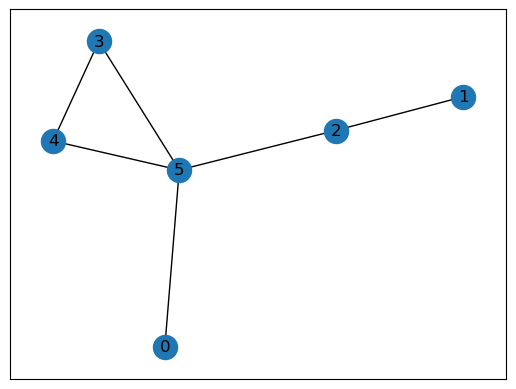

In [13]:
GA = functions.random_graph_generation(6, 0.35,3 , 1)
nx.draw_networkx(GA)



In [ ]:
##The lines we've added starts here

  0%|                                                     | 0/3 [00:00<?, ?it/s]

Number of combinations for subgraphs: 20


 33%|██████████████▋                             | 1/3 [02:26<04:53, 146.66s/it]

Number of samples:  100 
Total samples generated: 285000
Number of combinations for subgraphs: 20


 67%|█████████████████████████████▎              | 2/3 [05:17<02:40, 160.62s/it]

Number of samples:  100 
Total samples generated: 320000
Number of combinations for subgraphs: 20


100%|████████████████████████████████████████████| 3/3 [08:06<00:00, 162.15s/it]


Number of samples:  100 
Total samples generated: 320400


  0%|                                                     | 0/3 [00:00<?, ?it/s]

Number of combinations for subgraphs: 10


 33%|███████████████                              | 1/3 [00:40<01:21, 40.53s/it]

Number of samples:  100 
Total samples generated: 104800
Number of combinations for subgraphs: 10


 67%|██████████████████████████████               | 2/3 [01:45<00:54, 54.74s/it]

Number of samples:  100 
Total samples generated: 159000
Number of combinations for subgraphs: 10


100%|█████████████████████████████████████████████| 3/3 [02:43<00:00, 54.64s/it]


Number of samples:  100 
Total samples generated: 148200


  0%|                                                     | 0/3 [00:00<?, ?it/s]

Number of combinations for subgraphs: 4


 33%|███████████████                              | 1/3 [00:05<00:10,  5.16s/it]

Number of samples:  101 
Total samples generated: 15800
Number of combinations for subgraphs: 4


 67%|██████████████████████████████               | 2/3 [00:11<00:05,  5.61s/it]

Number of samples:  100 
Total samples generated: 17800
Number of combinations for subgraphs: 4


100%|█████████████████████████████████████████████| 3/3 [00:15<00:00,  5.21s/it]


Number of samples:  100 
Total samples generated: 15400


  0%|                                                     | 0/3 [00:00<?, ?it/s]

Number of combinations for subgraphs: 1


 33%|███████████████                              | 1/3 [00:00<00:00,  2.12it/s]

Number of samples:  118 
Total samples generated: 1800
Number of combinations for subgraphs: 1


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  2.33it/s]

Number of samples:  118 
Total samples generated: 1600
Number of combinations for subgraphs: 1


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.19it/s]

Number of samples:  107 
Total samples generated: 2000
[160.22054233333333, 53.95332033333333, 5.114353000000013, 0.4607283333333119]


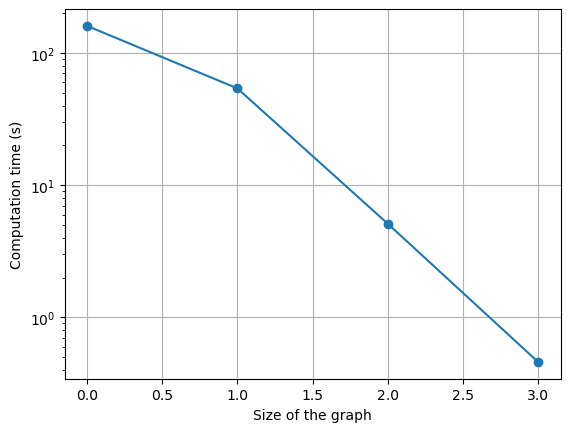

In [15]:
## Code in order to study classical impact


import time
from time import process_time 
from tqdm import tqdm
Ltime=[]

start_time = process_time()
for j in tqdm(range(0,3)):
    res = densest_subgraphs(GA,[] , 3, 200, Ns_min=100)
end_time=process_time()
T=-(start_time-end_time)/3
Ltime.append(T)


start_time = process_time()
for j in tqdm(range(0,3)):
    res = densest_subgraphs(GA,[5] , 3, 200, Ns_min=100)
end_time=process_time()
T=-(start_time-end_time)/3
Ltime.append(T)

start_time = process_time()
for j in tqdm(range(0,3)):
    res = densest_subgraphs(GA,[5,4] , 3, 200, Ns_min=100)
end_time=process_time()
T=-(start_time-end_time)/3
Ltime.append(T)

start_time = process_time()
for j in tqdm(range(0,3)):
    res = densest_subgraphs(GA,[5,4,3] , 3, 200, Ns_min=100)
end_time=process_time()
T=-(start_time-end_time)/3
Ltime.append(T)

import matplotlib.pyplot as plt

Lj=[0,1,2,3]
plt.plot(Lj,Ltime,'o-')
plt.grid()
print(Ltime)
plt.yscale("log")
plt.xlabel('Size of the graph')
plt.ylabel('Computation time (s)')
plt.savefig('project-densest-graph-d')
plt.show()

[160.22054233333333, 53.95332033333333, 5.114353000000013, 0.4607283333333119]


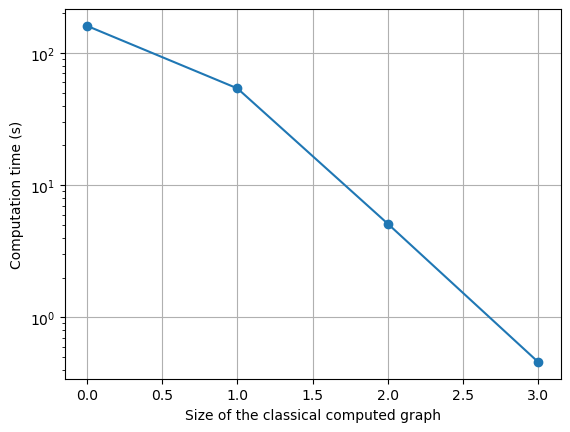

In [16]:
Lj=[0,1,2,3]
plt.plot(Lj,Ltime,'o-')
plt.grid()
print(Ltime)
plt.yscale("log")
plt.xlabel('Size of the classical computed graph')
plt.ylabel('Computation time (s)')
plt.savefig('project-densest-graph-d')
plt.show()

  0%|                                                     | 0/5 [00:00<?, ?it/s]

5
Number of combinations for subgraphs: 4



 20%|█████████                                    | 1/5 [00:20<01:21, 20.37s/it]

Number of samples:  200 
Total samples generated: 46200
[(112.0, [0, 1, 2]), (88.0, [1, 2, 3]), (0.0, [0, 2, 3]), (0.0, [0, 1, 3])]
5
Number of combinations for subgraphs: 4



 40%|██████████████████                           | 2/5 [00:43<01:05, 21.77s/it]

Number of samples:  200 
Total samples generated: 54200
[(61.0, [1, 2, 3]), (54.0, [0, 1, 3]), (46.0, [0, 2, 3]), (39.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 4



 60%|███████████████████████████                  | 3/5 [00:54<00:34, 17.24s/it]

Number of samples:  200 
Total samples generated: 28400
[(200.0, [1, 2, 3]), (0.0, [0, 2, 3]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 4



 80%|████████████████████████████████████         | 4/5 [01:12<00:17, 17.32s/it]

Number of samples:  202 
Total samples generated: 42400
[(108.0, [1, 2, 3]), (94.0, [0, 2, 3]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 4



 14%|██████▍                                      | 1/7 [01:29<08:57, 89.61s/it]

Number of samples:  200 
Total samples generated: 41800
[(113.0, [1, 2, 3]), (87.0, [0, 1, 3]), (0.0, [0, 2, 3]), (0.0, [0, 1, 2])]



  0%|                                                     | 0/5 [00:00<?, ?it/s]

5
Number of combinations for subgraphs: 10



 20%|█████████                                    | 1/5 [01:25<05:43, 85.95s/it]

Number of samples:  200 
Total samples generated: 168000
[(200.0, [2, 3, 4]), (0.0, [1, 3, 4]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 3, 4]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 10



 40%|██████████████████                           | 2/5 [02:53<04:21, 87.00s/it]

Number of samples:  200 
Total samples generated: 170200
[(104.0, [2, 3, 4]), (96.0, [0, 3, 4]), (0.0, [1, 3, 4]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 10



 60%|███████████████████████████                  | 3/5 [04:39<03:10, 95.38s/it]

Number of samples:  200 
Total samples generated: 205400
[(71.0, [2, 3, 4]), (71.0, [1, 2, 4]), (58.0, [0, 1, 4]), (0.0, [1, 3, 4]), (0.0, [1, 2, 3]), (0.0, [0, 3, 4]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 10



 80%|████████████████████████████████████         | 4/5 [06:07<01:32, 92.48s/it]

Number of samples:  200 
Total samples generated: 169800
[(106.0, [1, 2, 3]), (94.0, [2, 3, 4]), (0.0, [1, 3, 4]), (0.0, [1, 2, 4]), (0.0, [0, 3, 4]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 10



 29%|████████████▌                               | 2/7 [09:05<25:26, 305.30s/it]

Number of samples:  200 
Total samples generated: 174200
[(200.0, [2, 3, 4]), (0.0, [1, 3, 4]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 3, 4]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]



  0%|                                                     | 0/5 [00:00<?, ?it/s]

5
Number of combinations for subgraphs: 20



 20%|████████▊                                   | 1/5 [09:41<38:44, 581.21s/it]

Number of samples:  200 
Total samples generated: 859600
[(44.0, [3, 4, 5]), (44.0, [2, 4, 5]), (41.0, [2, 3, 4]), (37.0, [2, 3, 5]), (34.0, [1, 3, 4]), (0.0, [1, 4, 5]), (0.0, [1, 3, 5]), (0.0, [1, 2, 5]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 4, 5]), (0.0, [0, 3, 5]), (0.0, [0, 3, 4]), (0.0, [0, 2, 5]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 5]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 20



 40%|█████████████████▌                          | 2/5 [16:18<23:38, 472.97s/it]

Number of samples:  200 
Total samples generated: 589600
[(49.0, [2, 3, 4]), (41.0, [2, 4, 5]), (38.0, [3, 4, 5]), (37.0, [2, 3, 5]), (35.0, [1, 3, 4]), (0.0, [1, 4, 5]), (0.0, [1, 3, 5]), (0.0, [1, 2, 5]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 4, 5]), (0.0, [0, 3, 5]), (0.0, [0, 3, 4]), (0.0, [0, 2, 5]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 5]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 20



 60%|██████████████████████████▍                 | 3/5 [23:31<15:09, 454.54s/it]

Number of samples:  200 
Total samples generated: 636800
[(42.0, [3, 4, 5]), (42.0, [2, 3, 4]), (41.0, [2, 4, 5]), (41.0, [2, 3, 5]), (34.0, [0, 2, 3]), (0.0, [1, 4, 5]), (0.0, [1, 3, 5]), (0.0, [1, 3, 4]), (0.0, [1, 2, 5]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 4, 5]), (0.0, [0, 3, 5]), (0.0, [0, 3, 4]), (0.0, [0, 2, 5]), (0.0, [0, 2, 4]), (0.0, [0, 1, 5]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 20



 80%|███████████████████████████████████▏        | 4/5 [32:55<08:17, 497.82s/it]

Number of samples:  200 
Total samples generated: 833000
[(41.0, [1, 2, 4]), (38.0, [2, 3, 5]), (34.0, [2, 4, 5]), (31.0, [0, 1, 2]), (30.0, [3, 4, 5]), (26.0, [2, 3, 4]), (0.0, [1, 4, 5]), (0.0, [1, 3, 5]), (0.0, [1, 3, 4]), (0.0, [1, 2, 5]), (0.0, [1, 2, 3]), (0.0, [0, 4, 5]), (0.0, [0, 3, 5]), (0.0, [0, 3, 4]), (0.0, [0, 2, 5]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 5]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3])]
5
Number of combinations for subgraphs: 20



 43%|█████████████████▌                       | 3/7 [48:56<1:23:49, 1257.48s/it]

Number of samples:  200 
Total samples generated: 613800
[(50.0, [2, 4, 5]), (45.0, [2, 3, 5]), (42.0, [3, 4, 5]), (37.0, [2, 3, 4]), (26.0, [1, 3, 4]), (0.0, [1, 4, 5]), (0.0, [1, 3, 5]), (0.0, [1, 2, 5]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 4, 5]), (0.0, [0, 3, 5]), (0.0, [0, 3, 4]), (0.0, [0, 2, 5]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 5]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]



  0%|                                                     | 0/5 [00:00<?, ?it/s]

5
Number of combinations for subgraphs: 35



 20%|████████▏                                | 1/5 [18:08<1:12:34, 1088.59s/it]

Number of samples:  200 
Total samples generated: 1174800
[(62.0, [4, 5, 6]), (56.0, [3, 4, 6]), (46.0, [3, 4, 5]), (36.0, [3, 5, 6]), (0.0, [2, 5, 6]), (0.0, [2, 4, 6]), (0.0, [2, 4, 5]), (0.0, [2, 3, 6]), (0.0, [2, 3, 5]), (0.0, [2, 3, 4]), (0.0, [1, 5, 6]), (0.0, [1, 4, 6]), (0.0, [1, 4, 5]), (0.0, [1, 3, 6]), (0.0, [1, 3, 5]), (0.0, [1, 3, 4]), (0.0, [1, 2, 6]), (0.0, [1, 2, 5]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 5, 6]), (0.0, [0, 4, 6]), (0.0, [0, 4, 5]), (0.0, [0, 3, 6]), (0.0, [0, 3, 5]), (0.0, [0, 3, 4]), (0.0, [0, 2, 6]), (0.0, [0, 2, 5]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 6]), (0.0, [0, 1, 5]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 35



 40%|█████████████████▏                         | 2/5 [36:52<55:27, 1109.21s/it]

Number of samples:  200 
Total samples generated: 1224800
[(60.0, [4, 5, 6]), (55.0, [3, 4, 5]), (44.0, [3, 5, 6]), (41.0, [3, 4, 6]), (0.0, [2, 5, 6]), (0.0, [2, 4, 6]), (0.0, [2, 4, 5]), (0.0, [2, 3, 6]), (0.0, [2, 3, 5]), (0.0, [2, 3, 4]), (0.0, [1, 5, 6]), (0.0, [1, 4, 6]), (0.0, [1, 4, 5]), (0.0, [1, 3, 6]), (0.0, [1, 3, 5]), (0.0, [1, 3, 4]), (0.0, [1, 2, 6]), (0.0, [1, 2, 5]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 5, 6]), (0.0, [0, 4, 6]), (0.0, [0, 4, 5]), (0.0, [0, 3, 6]), (0.0, [0, 3, 5]), (0.0, [0, 3, 4]), (0.0, [0, 2, 6]), (0.0, [0, 2, 5]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 6]), (0.0, [0, 1, 5]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 35



 60%|█████████████████████████▊                 | 3/5 [53:59<35:43, 1071.62s/it]

Number of samples:  200 
Total samples generated: 1124600
[(57.0, [3, 4, 5]), (46.0, [2, 3, 6]), (42.0, [3, 5, 6]), (28.0, [3, 4, 6]), (27.0, [4, 5, 6]), (0.0, [2, 5, 6]), (0.0, [2, 4, 6]), (0.0, [2, 4, 5]), (0.0, [2, 3, 5]), (0.0, [2, 3, 4]), (0.0, [1, 5, 6]), (0.0, [1, 4, 6]), (0.0, [1, 4, 5]), (0.0, [1, 3, 6]), (0.0, [1, 3, 5]), (0.0, [1, 3, 4]), (0.0, [1, 2, 6]), (0.0, [1, 2, 5]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 5, 6]), (0.0, [0, 4, 6]), (0.0, [0, 4, 5]), (0.0, [0, 3, 6]), (0.0, [0, 3, 5]), (0.0, [0, 3, 4]), (0.0, [0, 2, 6]), (0.0, [0, 2, 5]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 6]), (0.0, [0, 1, 5]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 35



 80%|████████████████████████████████▊        | 4/5 [1:17:57<20:16, 1216.37s/it]

Number of samples:  200 
Total samples generated: 1564400
[(43.0, [3, 5, 6]), (40.0, [3, 4, 6]), (40.0, [3, 4, 5]), (40.0, [0, 1, 4]), (37.0, [4, 5, 6]), (0.0, [2, 5, 6]), (0.0, [2, 4, 6]), (0.0, [2, 4, 5]), (0.0, [2, 3, 6]), (0.0, [2, 3, 5]), (0.0, [2, 3, 4]), (0.0, [1, 5, 6]), (0.0, [1, 4, 6]), (0.0, [1, 4, 5]), (0.0, [1, 3, 6]), (0.0, [1, 3, 5]), (0.0, [1, 3, 4]), (0.0, [1, 2, 6]), (0.0, [1, 2, 5]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 5, 6]), (0.0, [0, 4, 6]), (0.0, [0, 4, 5]), (0.0, [0, 3, 6]), (0.0, [0, 3, 5]), (0.0, [0, 3, 4]), (0.0, [0, 2, 6]), (0.0, [0, 2, 5]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 6]), (0.0, [0, 1, 5]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]
5
Number of combinations for subgraphs: 35



 57%|██████████████████████▎                | 4/7 [2:24:33<2:31:17, 3025.90s/it]

Number of samples:  200 
Total samples generated: 1156800
[(60.0, [3, 4, 6]), (56.0, [4, 5, 6]), (42.0, [3, 5, 6]), (42.0, [3, 4, 5]), (0.0, [2, 5, 6]), (0.0, [2, 4, 6]), (0.0, [2, 4, 5]), (0.0, [2, 3, 6]), (0.0, [2, 3, 5]), (0.0, [2, 3, 4]), (0.0, [1, 5, 6]), (0.0, [1, 4, 6]), (0.0, [1, 4, 5]), (0.0, [1, 3, 6]), (0.0, [1, 3, 5]), (0.0, [1, 3, 4]), (0.0, [1, 2, 6]), (0.0, [1, 2, 5]), (0.0, [1, 2, 4]), (0.0, [1, 2, 3]), (0.0, [0, 5, 6]), (0.0, [0, 4, 6]), (0.0, [0, 4, 5]), (0.0, [0, 3, 6]), (0.0, [0, 3, 5]), (0.0, [0, 3, 4]), (0.0, [0, 2, 6]), (0.0, [0, 2, 5]), (0.0, [0, 2, 4]), (0.0, [0, 2, 3]), (0.0, [0, 1, 6]), (0.0, [0, 1, 5]), (0.0, [0, 1, 4]), (0.0, [0, 1, 3]), (0.0, [0, 1, 2])]



 57%|██████████████████████▎                | 4/7 [2:24:33<1:48:25, 2168.36s/it]

5
Number of combinations for subgraphs: 56


RuntimeError: Fock state size is capped from 0 to 256 modes (336 received)

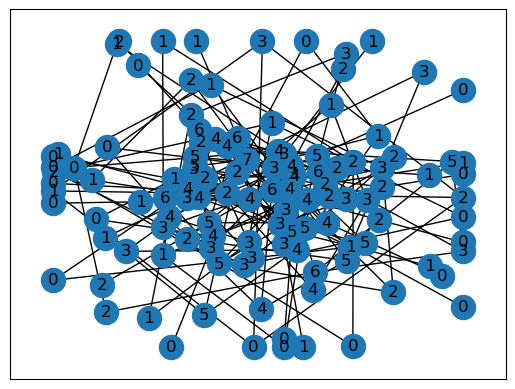

In [15]:
## Code to study time complexity with respect to the scale of the graph
import time
from time import process_time 
from tqdm import tqdm
Ltime=[]
for i in tqdm(range(4,11)):
    start_time = process_time()
    for j in tqdm(range(0,5)):
        GA = functions.random_graph_generation(i, 0.35, i//2+1, 1)
        nx.draw_networkx(GA)   
        print(5)
        res = densest_subgraphs(GA,[], 3, 200, Ns_min=200)
        print(res)
    end_time=process_time()
    T=-(start_time-end_time)/5
    Ltime.append(T)
print(Ltime)

Here we generate a graph and test with two seeds: $[4]$ and $[2,4]$. For the first, the code returns that $102$ samples selected the subgraph $[4,0,2]$ and $98$ samples selected $[4,3,5]$. From the graph we can confirm that these are the denser ones with, in fact, equal density that is translated to the output of the program. Other subgraphs were not outputted. For second seed, it corrected outputted only the state for $[2,4,0]$.

In [18]:
import matplotlib.pyplot as plt

Lj=[4,5,6,7]


[17.872299000000005, 91.67316100000001, 479.18427999999994, 1147.7439668000002]


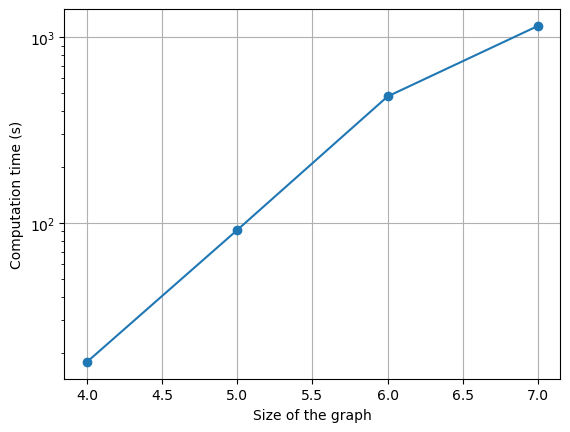

In [19]:
plt.plot(Lj,Ltime,'o-')
plt.grid()
print(Ltime)
plt.yscale("log")
plt.xlabel('Size of the graph')
plt.ylabel('Computation time (s)')
plt.savefig('project-densest-graph-d')
plt.show()
